# Exploring Kepler Non-Detections

- [Long Cadence](#Long-Cadence)
  - [Calculating Kepler flare maximum energy](#Calculating-Kepler-flare-maximum-energy)
  - [Individual flares](#Individual-flares)
- [Short Cadence](#Short-Cadence)
  - [Calculating Kepler flare maximum energy](#sc_max_eng)
  - [Individual flares](#sc_ind_flares)
- [Aggregate flares](#Aggregate-flares)

In [1]:
import sys
import requests

import numpy as np

import matplotlib
%matplotlib inline


import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib import cm

from mpl_toolkits.axes_grid1.inset_locator import inset_axes

from astropy.table import Table, Column
from astropy import units as u
from astropy.modeling import models
from astropy.visualization import LinearStretch, ManualInterval

from scipy.optimize import curve_fit

import arhap

sys.path.append('../src')
import energy

## Long Cadence

### Calculating Kepler flare maximum energy

Here we caculate the maximum energy over quiescent that could be present in the flare time bin that is consistent with observation.

In [2]:
lc_info_table = Table.read("../data_tables/kepler_longcad_info.ecsv", format="ascii.ecsv")
galex_flares = Table.read("../data_tables/galex_flare_stats.ecsv", format="ascii.ecsv")

**Creating a new table to hold simultaneous GALEX flares and Kepler data**

In [3]:
galex_overlap = galex_flares[(galex_flares["LC Quarter"] != -1)]

comparison_flare_table = Table(names=["KID", "GID", "dist", "g_start_time", "g_end_time",
                                      "g_peak_flux", "g_qui_flux", "g_qui_flux_err", "g_duration",
                                      "g_E", "g_E_lo", "g_E_hi", "g_E_bol"],
                               data=[galex_overlap["KID"], galex_overlap["GID"], galex_overlap["Dist"],
                                     galex_overlap["Start"], galex_overlap["End"],
                                     galex_overlap["Peak Flux"], galex_overlap["Qui Flux"], 
                                     galex_overlap["Qui Flux Error"], galex_overlap["Duration"],
                                     galex_overlap["Ebol"]*0.106, 
                                     galex_overlap["e_Ebol"]*0.106, galex_overlap["E_Ebol"]*0.106, 
                                     galex_overlap["Ebol"]])

In [4]:
comparison_flare_table["k_path"] = [lc_info_table["path"][lc_info_table["KID"]==kid][0] for kid in comparison_flare_table["KID"]]

**Adding Kepler info**

In [5]:
comparison_flare_table.add_column(Column(name="k_qui_m", dtype=float, length=len(comparison_flare_table)))
comparison_flare_table.add_column(Column(name="k_qui_b", dtype=float, length=len(comparison_flare_table)))
comparison_flare_table.add_column(Column(name="k_qui_std", dtype=float, length=len(comparison_flare_table)))
comparison_flare_table.add_column(Column(name="k_ind", dtype=int, length=len(comparison_flare_table)))
comparison_flare_table.add_column(Column(name="k_deltf", dtype=float, length=len(comparison_flare_table)))
comparison_flare_table.add_column(Column(name="k_deltf_err", dtype=float, length=len(comparison_flare_table)))
comparison_flare_table.add_column(Column(name="k_deltf_max", dtype=float, length=len(comparison_flare_table)))
comparison_flare_table.add_column(Column(name="k_E_max", dtype=float, length=len(comparison_flare_table)))
comparison_flare_table.add_column(Column(name="k_E_max_bol", dtype=float, length=len(comparison_flare_table)))

In [6]:
for flare in comparison_flare_table:

    star_info = lc_info_table[lc_info_table["KID"] == flare["KID"]][0]
    
    lc_table = Table.read(flare["k_path"])
    
    flare["k_ind"] = arhap.find_nearest(lc_table["time"].jd, flare["g_start_time"].jd)
    m,b,std = energy.calc_qui_flux_parms(lc_table, [flare["k_ind"], flare["k_ind"]])
    
    flare["k_qui_m"] = m
    flare["k_qui_b"] = b
    flare["k_qui_std"] = std
    
    flare_point = lc_table[flare["k_ind"]]
    flare["k_deltf"] = flare_point["flux"] - (m*flare_point['time'].jd+b)
    flare["k_deltf_err"] = np.sqrt(std**2 + flare_point['flux_err']**2)
    flare["k_deltf_max"] = flare["k_deltf"] + flare["k_deltf_err"]
    if flare["k_deltf_max"] < 0:
        flare["k_deltf_max"] = 0.0
    
    flare["k_E_max"] = energy.max_kepler_energy(flare["k_deltf_max"]*u.Unit("electron s-1"), 
                                                (m*flare_point['time'].jd+b)*u.Unit("electron s-1"),
                                                star_info["r_est"], star_info["E(B-V)"]).value
    
    
    flare["k_E_max_bol"] = flare["k_E_max"]*0.16

**Adding radius, luminosity, and teff columns**

We use the 4" table from https://gaia-kepler.fun/.

In [7]:
resp = requests.get("https://www.dropbox.com/s/v070hmvhm2ezjax/kepler_dr2_4arcsec.fits?dl=1")

with open("../data_tables/kepler_dr2_4arcsec.fits", 'wb') as FLE:
    FLE.write(resp.content)

In [8]:
sd2 = Table.read("../data_tables/kepler_dr2_4arcsec.fits")

In [5]:
# this step takes a few minutes
comparison_flare_table["Lum"] = [sd2["lum_val"][sd2["kepid"]==kid][0] if len(sd2["lum_val"][sd2["kepid"]==kid])>0 else 0 for kid in comparison_flare_table["KID"]]
comparison_flare_table["radius"] = [sd2["radius_val"][sd2["kepid"]==kid][0] if len(sd2["radius_val"][sd2["kepid"]==kid])>0 else 0 for kid in comparison_flare_table["KID"]]
comparison_flare_table["Teff"] = [sd2["teff"][sd2["kepid"]==kid][0] if len(sd2["teff"][sd2["kepid"]==kid])>0 else 0 for kid in comparison_flare_table["KID"]]

In [7]:
comparison_flare_table.write("../data_tables/galex_flare_kepler_nondetect.ecsv", format="ascii.ecsv")

### Individual flares

In [8]:
comparison_flare_table = Table.read("../data_tables/galex_flare_kepler_nondetect.ecsv", format="ascii.ecsv")

**One of the largest GALEX flares**

In [16]:
flare = comparison_flare_table[comparison_flare_table["KID"] == 9775887][-1]

kepler_lc = Table.read(flare["k_path"])
flare_row = kepler_lc[flare["k_ind"]]
kepler_lc = kepler_lc[(kepler_lc["time"] > (flare["g_start_time"] - 8*u.hr)) & (kepler_lc["time"] < (flare["g_end_time"] + 8*u.hr))]


galex_lc = Table.read(f"../light_curves/galex/{flare['GID']}_LC.ecsv")
galex_lc = galex_lc[(galex_lc["time"] > (flare["g_start_time"] - 30*u.min)) & (galex_lc["time"] < (flare["g_end_time"] + 30*u.min))]

<ipython-input-12-31f367b71678>:65: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


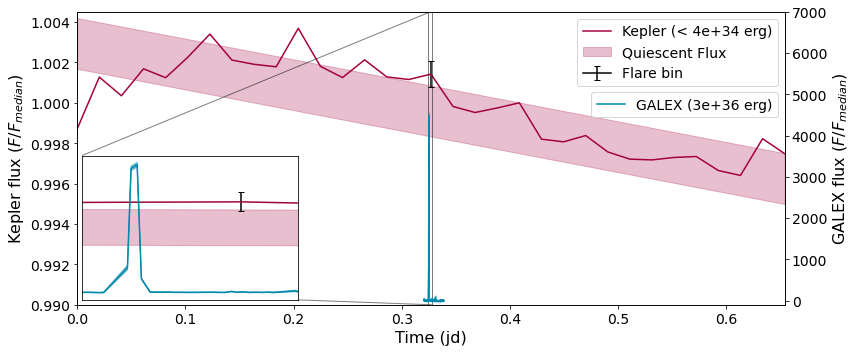

In [12]:
f, ax = plt.subplots(figsize=(12, 5))

st = kepler_lc['time'][0].jd

# Kepler
k_med = np.median(kepler_lc['flux']) # causes warning about ignoring the mask which is fine, we've already removed the masked values
ax.plot(kepler_lc['time'].jd - st, kepler_lc['flux']/k_med, color="#a3003e", label="Kepler (< 4e+34 erg)")

qui_flux = flare["k_qui_m"]*kepler_lc['time'].jd+flare["k_qui_b"]
ax.fill_between(kepler_lc['time'].jd-st, (qui_flux-flare["k_qui_std"])/k_med, (qui_flux+flare["k_qui_std"])/k_med,
                    color="#a3003e", alpha=0.25, label="Quiescent Flux")

ax.errorbar(flare_row['time'].jd-st, flare_row['flux']/k_med, yerr=flare_row['flux_err']/k_med, 
                color='black', capsize=3, label="Flare bin")

ax.set_ylim(.990, 1.0045)
ax.set_xlim(0, kepler_lc['time'].jd[-1] - st)

# GALEX
ax2 = ax.twinx()
g_med = np.median(galex_lc['flux_mcatbgsub_acorr'])

ax2.plot(galex_lc['time'].jd-st, galex_lc['flux_mcatbgsub_acorr']/g_med, color="#0089aa", label="GALEX (3e+36 erg)")
ax2.fill_between(galex_lc['time'].jd-st, (galex_lc['flux_mcatbgsub_acorr'] - galex_lc['flux_mcatbgsub_err'])/g_med, 
                 (galex_lc['flux_mcatbgsub_acorr'] + galex_lc['flux_mcatbgsub_err'])/g_med, color="#0089aa", alpha=0.5)

ax2.set_ylim(-100,7000)

ax.legend(fontsize=14, loc='upper right')
ax2.legend(fontsize=14, loc='upper right', bbox_to_anchor=(1, 0.75))

ax.tick_params(axis='both', labelsize=14)
ax2.tick_params(axis='both', labelsize=14)

ax.set_xlabel("Time (jd)", fontsize=16)
ax.set_ylabel("Kepler flux ($F/F_{median}$)", fontsize=16)
ax2.set_ylabel("GALEX flux ($F/F_{median}$)", fontsize=16)


# Zoomed inset
axins = inset_axes(ax, 3, 2, loc=3)
axins.set_xticks([]) 
axins.set_yticks([])

axins.plot(kepler_lc['time'].jd - st, kepler_lc['flux']/k_med, color="#a3003e")
axins.fill_between(kepler_lc['time'].jd-st, (qui_flux-flare["k_qui_std"])/k_med, (qui_flux+flare["k_qui_std"])/k_med,
                    color="#a3003e", alpha=0.25)
axins.errorbar(flare_row['time'].jd-st, flare_row['flux']/k_med, yerr=flare_row['flux_err']/k_med, 
                color='black', capsize=3)

axins2 = axins.twinx()
axins2.set_yticks([])
axins2.plot(galex_lc['time'].jd-st, galex_lc['flux_mcatbgsub_acorr']/g_med, color="#0089aa")
axins2.fill_between(galex_lc['time'].jd-st, (galex_lc['flux_mcatbgsub_acorr'] - galex_lc['flux_mcatbgsub_err'])/g_med, 
                 (galex_lc['flux_mcatbgsub_acorr'] + galex_lc['flux_mcatbgsub_err'])/g_med, color="#0089aa", alpha=0.5)

axins.set_xlim(.324,.328)

# mark the inset manually
ax.axvline(.324, lw=1, c='k',alpha=.5)
ax.axvline(.328, lw=1, c='k',alpha=.5)
ax.plot([.324,.005],[1.00445,0.9974],lw=1, c='k',alpha=.5)
ax.plot([.201,.328],[.99025,.990],lw=1, c='k',alpha=.5)

plt.tight_layout()

f.savefig("../plots/gk_flare_big.pdf")

plt.show()

**One of the smallest flares**

In [19]:
flare = comparison_flare_table[comparison_flare_table["KID"] == 11668732][0]

kepler_lc = Table.read(flare["k_path"])
flare_row = kepler_lc[flare["k_ind"]]
kepler_lc = kepler_lc[(kepler_lc["time"] > (flare["g_start_time"] - 8*u.hr)) & (kepler_lc["time"] < (flare["g_end_time"] + 8*u.hr))]


galex_lc = Table.read(f"../light_curves/galex/{flare['GID']}_LC.ecsv")
galex_lc = galex_lc[(galex_lc["time"] > (flare["g_start_time"] - 30*u.min)) & (galex_lc["time"] < (flare["g_end_time"] + 30*u.min))]

<ipython-input-20-e5e87cc3f9a0>:66: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


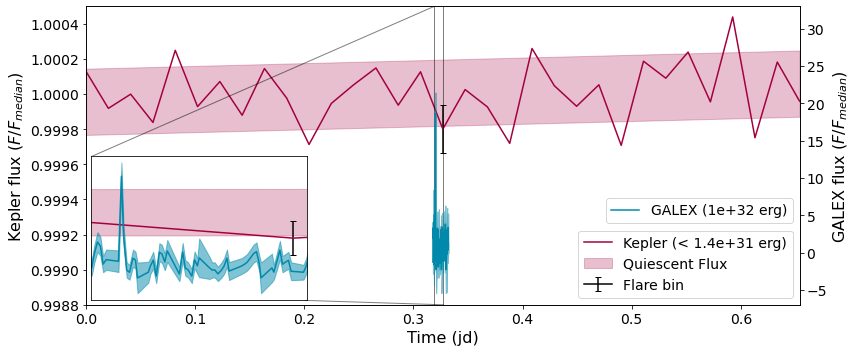

In [20]:
f, ax = plt.subplots(figsize=(12, 5))

st = kepler_lc['time'][0].jd

# Kepler
k_med = np.median(kepler_lc['flux']) # causes warning about ignoring the mask which is fine, we've already removed the masked values
ax.plot(kepler_lc['time'].jd - st, kepler_lc['flux']/k_med, color="#a3003e", label="Kepler (< 1.4e+31 erg)")

qui_flux = flare["k_qui_m"]*kepler_lc['time'].jd+flare["k_qui_b"]
ax.fill_between(kepler_lc['time'].jd-st, (qui_flux-flare["k_qui_std"])/k_med, (qui_flux+flare["k_qui_std"])/k_med,
                    color="#a3003e", alpha=0.25, label="Quiescent Flux")

ax.errorbar(flare_row['time'].jd-st, flare_row['flux']/k_med, yerr=flare_row['flux_err']/k_med, 
                color='black', capsize=3, label="Flare bin")

ax.set_ylim(.9988, 1.0005)
ax.set_xlim(0, kepler_lc['time'].jd[-1] - st)

# GALEX
ax2 = ax.twinx()
g_med = np.median(galex_lc['flux_mcatbgsub_acorr'])

ax2.plot(galex_lc['time'].jd-st, galex_lc['flux_mcatbgsub_acorr']/g_med, color="#0089aa", label="GALEX (1e+32 erg)")
ax2.fill_between(galex_lc['time'].jd-st, (galex_lc['flux_mcatbgsub_acorr'] - galex_lc['flux_mcatbgsub_err'])/g_med, 
                 (galex_lc['flux_mcatbgsub_acorr'] + galex_lc['flux_mcatbgsub_err'])/g_med, color="#0089aa", alpha=0.5)

ax2.set_ylim(-7,33)

ax.legend(fontsize=14, loc='lower right')
ax2.legend(fontsize=14, loc='lower right', bbox_to_anchor=(1, 0.25))

ax.tick_params(axis='both', labelsize=14)
ax2.tick_params(axis='both', labelsize=14)

ax.set_xlabel("Time (jd)", fontsize=16)
ax.set_ylabel("Kepler flux ($F/F_{median}$)", fontsize=16)
ax2.set_ylabel("GALEX flux ($F/F_{median}$)", fontsize=16)


# Zoomed inset
axins = inset_axes(ax, 3, 2, loc=3)
axins.set_xticks([]) 
axins.set_yticks([])

axins.plot(kepler_lc['time'].jd - st, kepler_lc['flux']/k_med, color="#a3003e")
axins.fill_between(kepler_lc['time'].jd-st, (qui_flux-flare["k_qui_std"])/k_med, (qui_flux+flare["k_qui_std"])/k_med,
                    color="#a3003e", alpha=0.25)
axins.errorbar(flare_row['time'].jd-st, flare_row['flux']/k_med, yerr=flare_row['flux_err']/k_med, 
                color='black', capsize=3)

axins2 = axins.twinx()
axins2.set_yticks([])
axins2.plot(galex_lc['time'].jd-st, galex_lc['flux_mcatbgsub_acorr']/g_med, color="#0089aa")
axins2.fill_between(galex_lc['time'].jd-st, (galex_lc['flux_mcatbgsub_acorr'] - galex_lc['flux_mcatbgsub_err'])/g_med, 
                 (galex_lc['flux_mcatbgsub_acorr'] + galex_lc['flux_mcatbgsub_err'])/g_med, color="#0089aa", alpha=0.5)

axins.set_xlim(.319,.3275)
axins.set_ylim(0.9993,1.00047)

# mark the inset manually
ax.axvline(.319, lw=1, c='k',alpha=.5)
ax.axvline(.3275, lw=1, c='k',alpha=.5)
ax.plot([.319,.005],[1.0005,0.999645],lw=1, c='k',alpha=.5)
ax.plot([.201,.3275],[.998825,.9988],lw=1, c='k',alpha=.5)

plt.tight_layout()

f.savefig("../plots/gk_flare_small.pdf")

plt.show()

**A medium sized flare**

In [44]:
flare = comparison_flare_table[comparison_flare_table["KID"] == 9775956][-2]

kepler_lc = Table.read(flare["k_path"])
flare_row = kepler_lc[flare["k_ind"]]
kepler_lc = kepler_lc[(kepler_lc["time"] > (flare["g_start_time"] - 8*u.hr)) & (kepler_lc["time"] < (flare["g_end_time"] + 8*u.hr))]


galex_lc = Table.read(f"../light_curves/galex/{flare['GID']}_LC.ecsv")
galex_lc = galex_lc[(galex_lc["time"] > (flare["g_start_time"] - 30*u.min)) & (galex_lc["time"] < (flare["g_end_time"] + 30*u.min))]

<ipython-input-49-b4a0b20b2db9>:65: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


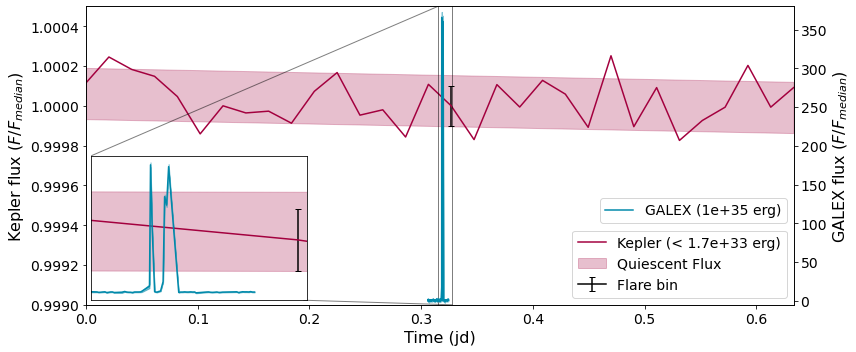

In [49]:
f, ax = plt.subplots(figsize=(12, 5))

st = kepler_lc['time'][0].jd

# Kepler
k_med = np.median(kepler_lc['flux']) # causes warning about ignoring the mask which is fine, we've already removed the masked values
ax.plot(kepler_lc['time'].jd - st, kepler_lc['flux']/k_med, color="#a3003e", label="Kepler (< 1.7e+33 erg)")

qui_flux = flare["k_qui_m"]*kepler_lc['time'].jd+flare["k_qui_b"]
ax.fill_between(kepler_lc['time'].jd-st, (qui_flux-flare["k_qui_std"])/k_med, (qui_flux+flare["k_qui_std"])/k_med,
                    color="#a3003e", alpha=0.25, label="Quiescent Flux")

ax.errorbar(flare_row['time'].jd-st, flare_row['flux']/k_med, yerr=flare_row['flux_err']/k_med, 
                color='black', capsize=3, label="Flare bin")

ax.set_ylim(.9990, 1.0005)
ax.set_xlim(0, kepler_lc['time'].jd[-1] - st)

# GALEX
ax2 = ax.twinx()
g_med = np.median(galex_lc['flux_mcatbgsub_acorr'])

ax2.plot(galex_lc['time'].jd-st, galex_lc['flux_mcatbgsub_acorr']/g_med, color="#0089aa", label="GALEX (1e+35 erg)")
ax2.fill_between(galex_lc['time'].jd-st, (galex_lc['flux_mcatbgsub_acorr'] - galex_lc['flux_mcatbgsub_err'])/g_med, 
                 (galex_lc['flux_mcatbgsub_acorr'] + galex_lc['flux_mcatbgsub_err'])/g_med, color="#0089aa", alpha=0.5)

ax2.set_ylim(-5,380)

ax.legend(fontsize=14, loc='lower right')
ax2.legend(fontsize=14, loc='lower right', bbox_to_anchor=(1, 0.25))

ax.tick_params(axis='both', labelsize=14)
ax2.tick_params(axis='both', labelsize=14)

ax.set_xlabel("Time (jd)", fontsize=16)
ax.set_ylabel("Kepler flux ($F/F_{median}$)", fontsize=16)
ax2.set_ylabel("GALEX flux ($F/F_{median}$)", fontsize=16)


# Zoomed inset
axins = inset_axes(ax, 3, 2, loc=3)
axins.set_xticks([]) 
axins.set_yticks([])

axins.plot(kepler_lc['time'].jd - st, kepler_lc['flux']/k_med, color="#a3003e")
axins.fill_between(kepler_lc['time'].jd-st, (qui_flux-flare["k_qui_std"])/k_med, (qui_flux+flare["k_qui_std"])/k_med,
                    color="#a3003e", alpha=0.25)
axins.errorbar(flare_row['time'].jd-st, flare_row['flux']/k_med, yerr=flare_row['flux_err']/k_med, 
                color='black', capsize=3)

axins2 = axins.twinx()
axins2.set_yticks([])
axins2.plot(galex_lc['time'].jd-st, galex_lc['flux_mcatbgsub_acorr']/g_med, color="#0089aa")
axins2.fill_between(galex_lc['time'].jd-st, (galex_lc['flux_mcatbgsub_acorr'] - galex_lc['flux_mcatbgsub_err'])/g_med, 
                 (galex_lc['flux_mcatbgsub_acorr'] + galex_lc['flux_mcatbgsub_err'])/g_med, color="#0089aa", alpha=0.5)

axins.set_xlim(.315,.3275)

# mark the inset manually
ax.axvline(.315, lw=1, c='k',alpha=.5)
ax.axvline(.3275, lw=1, c='k',alpha=.5)
ax.plot([.315,.005],[1.0005,0.99975],lw=1, c='k',alpha=.5)
ax.plot([.195,.3275],[.999023,.9990],lw=1, c='k',alpha=.5)

plt.tight_layout()

f.savefig("../plots/gk_flare_med.pdf")

plt.show()

## Short Cadence

### Calculating Kepler flare maximum energy <a id='sc_max_eng'></a>

Here we caculate the maximum energy over quiescent that could be present in the flare time bins that is consistent with observation.

In [123]:
sc_info_table = Table.read("../data_tables/kepler_shortcad_info.ecsv", format="ascii.ecsv")
galex_flares = Table.read("../data_tables/galex_flare_stats.ecsv", format="ascii.ecsv")

**Creating a new table to hold simultaneous GALEX flares and Kepler data**

In [124]:
galex_overlap = galex_flares[(galex_flares["SC Quarter"] != -1)]

sc_comparison_flares = Table(names=["KID", "GID", "dist", "E(B-V)", "g_start_time", "g_end_time",
                                      "g_peak_flux", "g_qui_flux", "g_qui_flux_err", "g_duration",
                                      "g_E", "g_E_lo", "g_E_hi", "g_E_bol"],
                               data=[galex_overlap["KID"], galex_overlap["GID"], 
                                     galex_overlap["Dist"], galex_overlap["E(B-V)"],
                                     galex_overlap["Start"], galex_overlap["End"],
                                     galex_overlap["Peak Flux"], galex_overlap["Qui Flux"], 
                                     galex_overlap["Qui Flux Error"], galex_overlap["Duration"],
                                     galex_overlap["Ebol"]*0.106, 
                                     galex_overlap["e_Ebol"]*0.106, galex_overlap["E_Ebol"]*0.106, 
                                     galex_overlap["Ebol"]])

In [125]:
sc_comparison_flares["k_path"] = [sc_info_table["path"][sc_info_table["KID"]==kid][0] for kid in sc_comparison_flares["KID"]]

**Adding Kepler info**

In [126]:
sc_comparison_flares.add_column(Column(name="k_qui_m", dtype=float, length=len(sc_comparison_flares)))
sc_comparison_flares.add_column(Column(name="k_qui_b", dtype=float, length=len(sc_comparison_flares)))
sc_comparison_flares.add_column(Column(name="k_qui_std", dtype=float, length=len(sc_comparison_flares)))
sc_comparison_flares.add_column(Column(name="k_start", dtype=int, length=len(sc_comparison_flares)))
sc_comparison_flares.add_column(Column(name="k_end", dtype=int, length=len(sc_comparison_flares)))
sc_comparison_flares.add_column(Column(name="k_peakf", dtype=float, length=len(sc_comparison_flares)))
sc_comparison_flares.add_column(Column(name="k_deltf_max", dtype=float, length=len(sc_comparison_flares)))
sc_comparison_flares.add_column(Column(name="k_E_max", dtype=float, length=len(sc_comparison_flares)))
sc_comparison_flares.add_column(Column(name="k_E_max_bol", dtype=float, length=len(sc_comparison_flares)))

In [177]:
for flare in sc_comparison_flares:

    star_info = sc_info_table[sc_info_table["KID"] == flare["KID"]][0]
    
    lc_table = Table.read(flare["k_path"])
    
    flare["k_start"] = np.where((lc_table["time"].jd -  flare["g_start_time"].jd) < 0)[0][-1] 
    flare["k_end"] = np.where((lc_table["time"].jd -  flare["g_end_time"].jd) > 0)[0][0]
    m,b,std = energy.calc_qui_flux_parms(lc_table, [flare["k_start"], flare["k_end"]])
    
    flare["k_qui_m"] = m
    flare["k_qui_b"] = b
    flare["k_qui_std"] = std
    
    flare_points = lc_table[flare["k_start"]:flare["k_end"]]
    qui_fluxes = (m*flare_points['time'].jd+b)
    delt_fluxes = flare_points["flux"] - qui_fluxes
    deltf_errs = np.sqrt(std**2 + flare_points['flux_err']**2)
    
    deltf_maxs = delt_fluxes + deltf_errs
    deltf_maxs[deltf_maxs < 0] = 0.0
    
    flare["k_deltf_max"] = sum(deltf_maxs)
    flare["k_peakf"] =  (qui_fluxes + deltf_maxs).max()
    
    deltf_max = energy.kepler_count_to_flux(flare["k_deltf_max"]+np.mean(qui_fluxes)) - energy.kepler_count_to_flux(np.mean(qui_fluxes))
    fluence = deltf_max*u.min
    ext_corr = 10**(energy.R_KEP * flare["E(B-V)"] * 2 / 5)
    fluence *= ext_corr
    dist = flare["dist"]*u.pc
    flare["k_E_max"] =  (4*np.pi*fluence*dist**2).to(u.erg).value
    flare["k_E_max_bol"] = flare["k_E_max"]/0.16

In [178]:
sc_comparison_flares.write("../data_tables/galex_flare_kepler_nondetect_sc.ecsv", format="ascii.ecsv")

### Individual flares  <a id='sc_ind_flares'></a>

There are only two flares with short cadence overlap (KIC 9592705), so we will look at them both.

In [211]:
sc_comparison_flares = Table.read("../data_tables/galex_flare_kepler_nondetect_sc.ecsv", format="ascii.ecsv")

In [212]:
kepler_lc = Table.read(sc_info_table[0]["path"])
galex_lc = Table.read(f"../light_curves/galex/GALEX_{sc_info_table['GID'][0]}_LC.ecsv")

In [213]:
flare = sc_comparison_flares[0]
galex_lc_lowres = Table.read(f"../light_curves/galex/GALEX_{sc_info_table['GID'][0]}_lowres.ecsv")

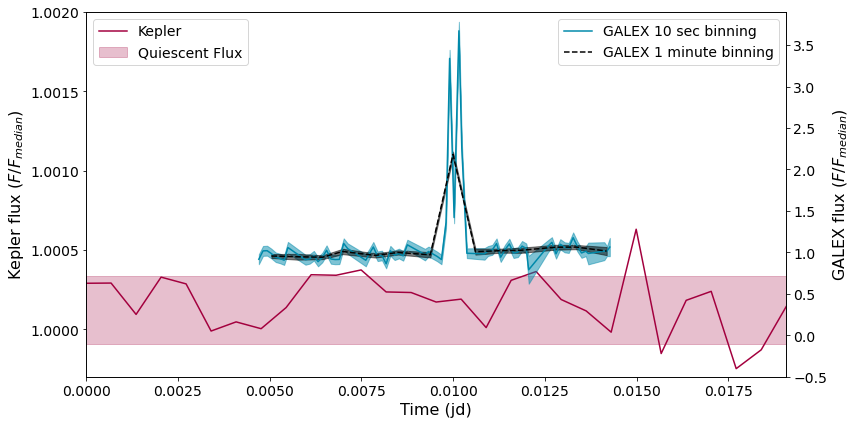

In [214]:
f, ax = plt.subplots(figsize=(12, 6))

kep_range = ((kepler_lc['time'].jd >= (galex_lc['time'].jd[0] -.005)) & 
             (kepler_lc['time'].jd <= (galex_lc['time'].jd[66]+.005)))
tmin = kepler_lc['time'][kep_range][0].jd

k_med = np.median(kepler_lc['flux'])

# Kepler
k_med = np.median(kepler_lc['flux'])
ax.plot(kepler_lc['time'][kep_range].jd - tmin, kepler_lc['flux'][kep_range]/k_med, color="#a3003e", label="Kepler")

qui_flux = flare["k_qui_m"]*kepler_lc['time'].jd+flare["k_qui_b"]
ax.fill_between(kepler_lc['time'][kep_range].jd-tmin, (qui_flux[kep_range]-flare["k_qui_std"])/k_med, 
                (qui_flux[kep_range]+flare["k_qui_std"])/k_med,
                    color="#a3003e", alpha=0.25, label="Quiescent Flux")


ax.set_ylim(.9997, 1.002)
ax.set_xlim(0, kepler_lc['time'][kep_range].jd[-1]-tmin)

# GALEX
ax2 = ax.twinx()
g_med = np.median(galex_lc['flux_mcatbgsub_acorr'])

ax2.plot(galex_lc['time'][:67].jd - tmin, galex_lc['flux_mcatbgsub_acorr'][:67]/g_med, color="#0089aa",
         label="GALEX 10 sec binning")
ax2.fill_between(galex_lc['time'][:67].jd - tmin, 
                 (galex_lc['flux_mcatbgsub_acorr'][:67]-galex_lc['flux_mcatbgsub_err'][:67])/g_med, 
                 (galex_lc['flux_mcatbgsub_acorr'][:67]+galex_lc['flux_mcatbgsub_err'][:67])/g_med,
                 color="#0089aa", alpha=0.5)

ax2.plot(galex_lc_lowres["time"].jd - tmin, galex_lc_lowres['flux_mcatbgsub_acorr']/g_med, "--", color="black",
         label="GALEX 1 minute binning")
ax2.fill_between(galex_lc_lowres['time'].jd - tmin, 
                 (galex_lc_lowres['flux_mcatbgsub_acorr']-galex_lc_lowres['flux_mcatbgsub_err'])/g_med, 
                 (galex_lc_lowres['flux_mcatbgsub_acorr']+galex_lc_lowres['flux_mcatbgsub_err'])/g_med,
                 color="k", alpha=0.5)

ax2.set_ylim(-0.5,3.9)

ax.legend(fontsize=14, loc='upper left')
ax2.legend(fontsize=14, loc='upper right')#, bbox_to_anchor=(1, 0.75))

ax.tick_params(axis='both', labelsize=14)
ax2.tick_params(axis='both', labelsize=14)

ax.set_xlabel("Time (jd)", fontsize=16)
ax.set_ylabel("Kepler flux ($F/F_{median}$)", fontsize=16)
ax2.set_ylabel("GALEX flux ($F/F_{median}$)", fontsize=16)


plt.tight_layout()

f.savefig("../plots/sc_gk_1.pdf")

plt.show()

In [216]:
flare = sc_comparison_flares[1]
galex_lc_lowres = Table.read(f"../light_curves/galex/GALEX_{sc_info_table['GID'][0]}_lowres_2.ecsv")

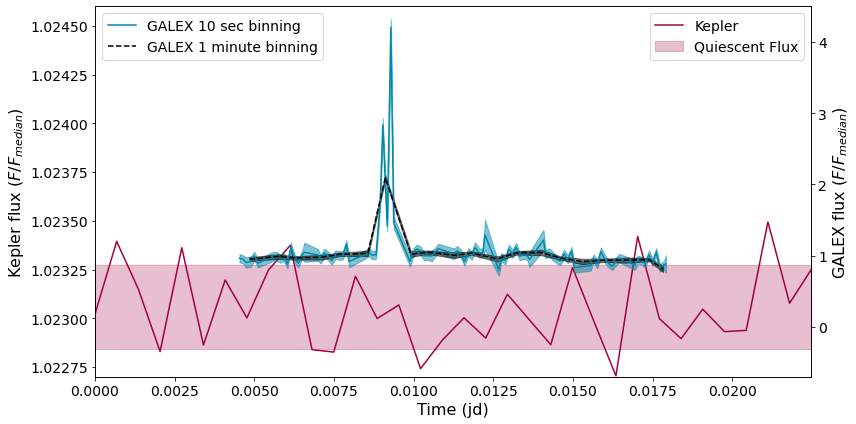

In [217]:
f, ax = plt.subplots(figsize=(12, 6))

kep_range = ((kepler_lc['time'].jd >= (galex_lc['time'].jd[67] -.005)) & 
             (kepler_lc['time'].jd <= (galex_lc['time'].jd[-1]+.005)))
tmin = kepler_lc['time'][kep_range][0].jd

k_med = np.median(kepler_lc['flux'])

# Kepler
k_med = np.median(kepler_lc['flux'])
ax.plot(kepler_lc['time'][kep_range].jd - tmin, kepler_lc['flux'][kep_range]/k_med, color="#a3003e", label="Kepler")

qui_flux = flare["k_qui_m"]*kepler_lc['time'].jd+flare["k_qui_b"]
ax.fill_between(kepler_lc['time'][kep_range].jd-tmin, (qui_flux[kep_range]-flare["k_qui_std"])/k_med, 
                (qui_flux[kep_range]+flare["k_qui_std"])/k_med,
                    color="#a3003e", alpha=0.25, label="Quiescent Flux")

ax.set_ylim(1.0227, 1.0246)
ax.set_xlim(0, kepler_lc['time'][kep_range].jd[-1]-tmin)

# GALEX
ax2 = ax.twinx()
g_med = np.median(galex_lc['flux_mcatbgsub_acorr'])

ax2.plot(galex_lc['time'][67:].jd - tmin, galex_lc['flux_mcatbgsub_acorr'][67:]/g_med, color="#0089aa",
         label="GALEX 10 sec binning")
ax2.fill_between(galex_lc['time'][67:].jd - tmin, 
                 (galex_lc['flux_mcatbgsub_acorr'][67:]-galex_lc['flux_mcatbgsub_err'][67:])/g_med, 
                 (galex_lc['flux_mcatbgsub_acorr'][67:]+galex_lc['flux_mcatbgsub_err'][67:])/g_med,
                 color="#0089aa", alpha=0.5)

ax2.plot(galex_lc_lowres["time"].jd - tmin, galex_lc_lowres['flux_mcatbgsub_acorr']/g_med, "--", color="black",
         label="GALEX 1 minute binning")
ax2.fill_between(galex_lc_lowres['time'].jd - tmin, 
                 (galex_lc_lowres['flux_mcatbgsub_acorr']-galex_lc_lowres['flux_mcatbgsub_err'])/g_med, 
                 (galex_lc_lowres['flux_mcatbgsub_acorr']+galex_lc_lowres['flux_mcatbgsub_err'])/g_med,
                 color="k", alpha=0.5)

ax2.set_ylim(-.7,4.5)

ax.legend(fontsize=14, loc='upper right')
ax2.legend(fontsize=14, loc='upper left')#, bbox_to_anchor=(1, 0.75))

ax.tick_params(axis='both', labelsize=14)
ax2.tick_params(axis='both', labelsize=14)

ax.set_xlabel("Time (jd)", fontsize=16)
ax.set_ylabel("Kepler flux ($F/F_{median}$)", fontsize=16)
ax2.set_ylabel("GALEX flux ($F/F_{median}$)", fontsize=16)


plt.tight_layout()

f.savefig("../plots/sc_gk_2.pdf")

plt.show()

## Aggregate flares

Fitting a line to GALEX flare energy vs maximum Kepler energy/GALEX flare energy ratio.

In [189]:
comparison_flare_table = Table.read("../data_tables/galex_flare_kepler_nondetect.ecsv", format="ascii.ecsv")
sc_comparison_flares = Table.read("../data_tables/galex_flare_kepler_nondetect_sc.ecsv", format="ascii.ecsv")

In [190]:
loc = comparison_flare_table["k_E_max_bol"] != 0 # removing the ones where there is no Kepler data

log_x = np.log(comparison_flare_table["g_E"][loc])
log_y = np.log(comparison_flare_table["k_E_max"][loc]/comparison_flare_table["g_E"][loc])

popt, pcov = curve_fit(energy.line_func, log_x, log_y)
m, b = popt

#### Looking more closely at the outliers

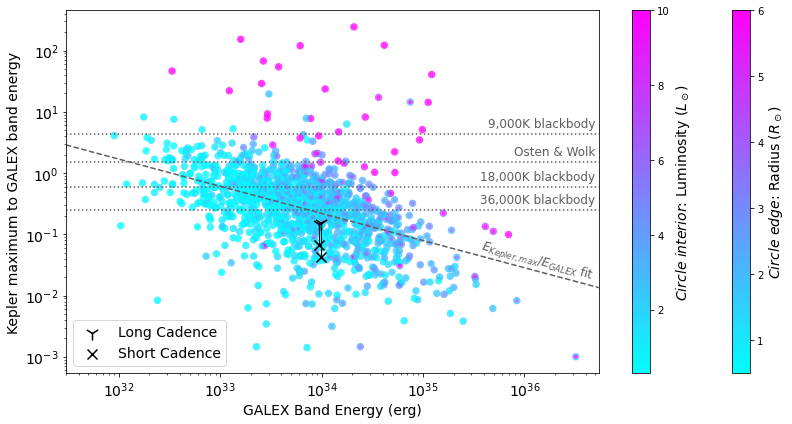

In [192]:
f, ax = plt.subplots(figsize=(12, 6))
ax.tick_params(axis='both', labelsize=14)

# Radius
loc2 = loc & ~np.isnan(comparison_flare_table["radius"])
transform = LinearStretch()+ ManualInterval(0.5,6)
colors = [cm.cool(color) for color in transform(comparison_flare_table["radius"][loc2])]
ax.scatter(comparison_flare_table["g_E"][loc2],
           comparison_flare_table["k_E_max"][loc2]/comparison_flare_table["g_E"][loc2],  
           linestyle='None',marker='o', facecolors="none", linewidths=2,
           alpha=0.75, s=30, edgecolors=colors)



sc = ax.scatter([],[],c=[], cmap='cool', vmin=0.5, vmax=6, alpha=1)
cbar = plt.colorbar(sc, pad=0)
cbar.ax.set_ylabel('$Circle$ $edge$: Radius ($R_\odot$)', fontsize=14)


## Luminosity
ax.scatter(comparison_flare_table["g_E"][loc],
           comparison_flare_table["k_E_max"][loc]/comparison_flare_table["g_E"][loc],  
           linestyle='None',marker='o', c=comparison_flare_table["Lum"][loc], cmap='cool',
           alpha=0.75, s=8, vmin=0.3, vmax=10)

sc = ax.scatter([],[],c=[], cmap='cool', vmin=0.3, vmax=10)
cbar = plt.colorbar(sc)
cbar.ax.set_ylabel('$Circle$ $interior$: Luminosity ($L_\odot$)', fontsize=14)

## Adding the short cadence data
corresp_in_lc = comparison_flare_table[comparison_flare_table["KID"] == sc_comparison_flares["KID"][0]]
ax.scatter(corresp_in_lc["g_E"], corresp_in_lc["k_E_max"]/sc_comparison_flares["g_E"], 
           marker='1', c="k", s=200, label="Long Cadence")

ax.scatter(sc_comparison_flares["g_E"], sc_comparison_flares["k_E_max"]/sc_comparison_flares["g_E"], 
           marker='x', c="k", s=100, label="Short Cadence")

ax.plot([sc_comparison_flares["g_E"][0], corresp_in_lc["g_E"][0]],
        [(sc_comparison_flares["k_E_max"]/sc_comparison_flares["g_E"])[0], 
         (corresp_in_lc["k_E_max"]/corresp_in_lc["g_E"])[0]],color='k',lw=1)
ax.plot([sc_comparison_flares["g_E"][1], corresp_in_lc["g_E"][1]],
        [(sc_comparison_flares["k_E_max"]/sc_comparison_flares["g_E"])[1], 
         (corresp_in_lc["k_E_max"]/corresp_in_lc["g_E"])[1]],color='k',lw=1)

ax.legend(loc="lower left", fontsize=14)

frac = .16/.106
ax.axhline(frac, color="#5e5e5e", ls=":")
ax.text(x=5*10**36, y=frac, s="Osten & Wolk\n", va='bottom', ha="right", linespacing=.1, color="#5e5e5e", fontsize=12)

bb = models.BlackBody(temperature=9000*u.K)
frac = bb(arhap.Kepler_lamda)/bb(arhap.GALEX_lamda)
ax.axhline(frac, color="#5e5e5e", ls=":")
ax.text(x=5*10**36, y=frac, s="9,000K blackbody\n", va='bottom', ha="right", linespacing=.1, color="#5e5e5e", fontsize=12)

bb = models.BlackBody(temperature=18000*u.K)
frac = bb(arhap.Kepler_lamda)/bb(arhap.GALEX_lamda)
ax.axhline(frac, color="#5e5e5e", ls=":")
ax.text(x=5*10**36, y=frac, s="18,000K blackbody\n", va='bottom', ha="right", linespacing=.1, color="#5e5e5e", fontsize=12)

bb = models.BlackBody(temperature=36000*u.K)
frac = bb(arhap.Kepler_lamda)/bb(arhap.GALEX_lamda)
ax.axhline(frac, color="#5e5e5e", ls=":")
ax.text(x=5*10**36, y=frac, s="36,000K blackbody\n", va='bottom', ha="right", linespacing=.1, color="#5e5e5e", fontsize=12)

ax.set_xlabel("GALEX Band Energy (erg)", fontsize=14)
ax.set_ylabel("Kepler maximum to GALEX band energy", fontsize=14)

ax.set_xlim(3*1e+31, 5.40602514020026e+36)
#ax.set_ylim(0.003, 5000)

xes = np.linspace(*ax.get_xlim(),10)
ax.plot(xes, np.exp(b)*np.power(xes,m), "--", color="#5e5e5e")
ax.text(x=5*10**36, y=.015, s="$E_{Kepler,max}/E_{GALEX}$ fit", fontsize=12,
        va='bottom', ha="right", color="#5e5e5e", rotation=-15)

ax.loglog()
plt.tight_layout()

f.savefig("../plots/g2k_outliers.pdf")

plt.show()

#### Plotting the minimum detectable energy for each Kepler light curve versus the maximum energy for each flare non-detection

In [193]:
# removing the outliers from the previous plot 
loc &= ~((comparison_flare_table["Lum"] > 10) & (comparison_flare_table["radius"] > 5))

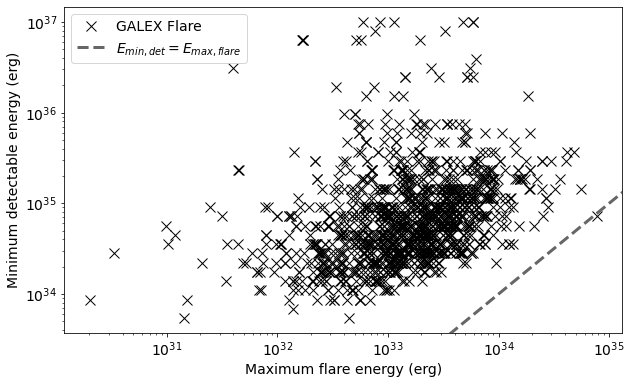

In [152]:
f, ax = plt.subplots(figsize=(10, 6))
ax.tick_params(axis='both', labelsize=14)

E_detectable = [lc_info_table[lc_info_table["KID"] == x]["min_det_eng"][0] for x in comparison_flare_table["KID"][loc]]

ax.plot(comparison_flare_table["k_E_max"][loc], E_detectable, 'x', color="k", ms=10, label="GALEX Flare")


#minval,maxval = np.min(recovered_injflare_table['inj_f_peak']), np.max(recovered_injflare_table['inj_f_peak'])
ax.plot([10**31,10**37],[10**31,10**37], '--', color='#666666', lw=3, label="$E_{min, det} = E_{max, flare}$")

ax.set_ylim(3.7e+33, 1.46e+37)
ax.set_xlim(1.18e+30, 1.31e+35)
ax.loglog()

ax.set_ylabel("Minimum detectable energy (erg)", fontsize=14)
ax.set_xlabel("Maximum flare energy (erg)", fontsize=14)
ax.legend(fontsize=14, loc="upper left")

f.savefig("../plots/E_detectable_vs_E_max.pdf")

plt.show()

#### Combing the non-detections with the catalog comparisions

We cross-matched the Yang catalog against our GALEX flare list, this time not looking for simultaneous data, just the presence of flares in both catalogs. We then collected a number of stellar properties for that data set, this is what is in the `overlapping_stellar_properties` table.

In [194]:
overlapping_stellar_properties = Table.read("../data_tables/overlapping_stellar_properties.ecsv", format="ascii.ecsv")

Using our own models.

In [195]:
# I am sure there is an easier way to do this, I can't be bothered to find it
gal_kep_ratios = list(Table.read("../data_tables/galkep_ratios.csv")[0].values())

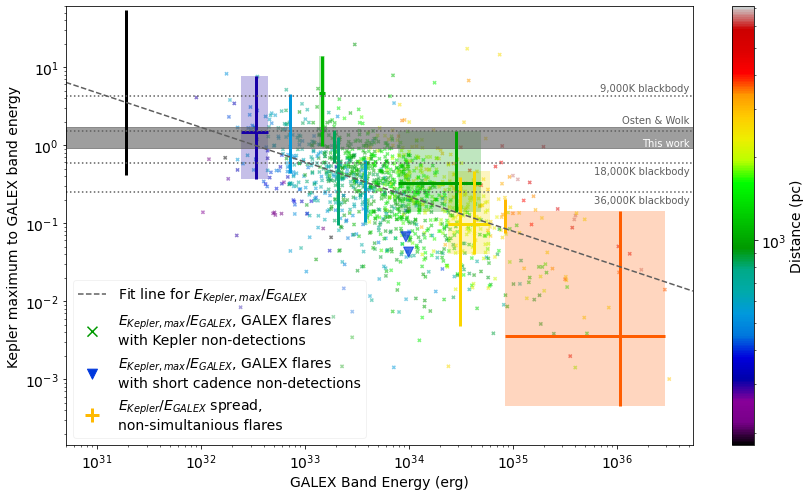

In [197]:
f, ax = plt.subplots(figsize=(12, 7))
ax.tick_params(axis='both', labelsize=14)

ax.scatter(comparison_flare_table["g_E"][loc],
           comparison_flare_table["k_E_max"][loc]/comparison_flare_table["g_E"][loc],  
           linestyle='None',marker='x', c=comparison_flare_table["dist"][loc], cmap='nipy_spectral',
           alpha=0.5, s=10, label="$E_{Kepler,max}/E_{GALEX}$, GALEX flares\nwith Kepler non-detections",
           norm=LogNorm(vmin=comparison_flare_table["dist"][loc].min(), 
                        vmax=comparison_flare_table["dist"][loc].max()+500))

ax.scatter(sc_comparison_flares["g_E"], sc_comparison_flares["k_E_max"]/sc_comparison_flares["g_E"], 
           marker='v', c=sc_comparison_flares["dist"], s=100, cmap='nipy_spectral',
           alpha=0.7, label="$E_{Kepler,max}/E_{GALEX}$, GALEX flares\nwith short cadence non-detections",
           norm=LogNorm(vmin=comparison_flare_table["dist"][loc].min(), 
                        vmax=comparison_flare_table["dist"][loc].max()+500))

sc = ax.scatter([],[],c=[], cmap='nipy_spectral',
                norm=LogNorm(vmin=comparison_flare_table["dist"][loc].min(), 
                             vmax=comparison_flare_table["dist"][loc].max()+500))

cbar = plt.colorbar(sc)
cbar.ax.set_ylabel('Distance (pc)', fontsize=14)
cbar.ax.tick_params(labelsize=14)

xerror = np.array([overlapping_stellar_properties["g_mean_e"] - overlapping_stellar_properties["g_min_e"], 
                   overlapping_stellar_properties["g_max_e"] - overlapping_stellar_properties["g_mean_e"]])
yerror = np.array([(overlapping_stellar_properties["k_mean_e"]/overlapping_stellar_properties["g_mean_e"]) - (overlapping_stellar_properties["k_max_e"]/overlapping_stellar_properties["g_min_e"]), 
                   (overlapping_stellar_properties["k_min_e"]/overlapping_stellar_properties["g_max_e"]) - (overlapping_stellar_properties["k_mean_e"]/overlapping_stellar_properties["g_mean_e"])])
                      
arhap.make_error_boxes(ax, xdata=overlapping_stellar_properties["g_mean_e"],
                 ydata=overlapping_stellar_properties["k_mean_e"]/overlapping_stellar_properties["g_mean_e"],
                 xerror=xerror, yerror=yerror, 
                 facecolor=cbar.mappable.to_rgba(overlapping_stellar_properties["dist"]), alpha=.25)

ax.errorbar(overlapping_stellar_properties["g_mean_e"], 
            overlapping_stellar_properties["k_mean_e"]/overlapping_stellar_properties["g_mean_e"], 
            xerr=xerror, yerr=yerror, fmt='None', label="$E_{Kepler}/E_{GALEX}$ spread,\nnon-simultanious flares",
            ecolor=cbar.mappable.to_rgba(overlapping_stellar_properties["dist"]), elinewidth=3)


frac = .16/.106
ax.axhline(frac, color="#5e5e5e", ls=":")
ax.text(x=5*10**36, y=frac, s="Osten & Wolk\n\n", va='bottom', ha="right", linespacing=.1, color="#5e5e5e")

bb = models.BlackBody(temperature=9000*u.K)
frac = bb(arhap.Kepler_lamda)/bb(arhap.GALEX_lamda)
ax.axhline(frac, color="#5e5e5e", ls=":")
ax.text(x=5*10**36, y=frac, s="9,000K blackbody\n", va='bottom', ha="right", linespacing=.1, color="#5e5e5e")

bb = models.BlackBody(temperature=18000*u.K)
frac = bb(arhap.Kepler_lamda)/bb(arhap.GALEX_lamda)
ax.axhline(frac, color="#5e5e5e", ls=":")
ax.text(x=5*10**36, y=frac, s="\n18,000K blackbody", va='top', ha="right", linespacing=.1, color="#5e5e5e")

bb = models.BlackBody(temperature=36000*u.K)
frac = bb(arhap.Kepler_lamda)/bb(arhap.GALEX_lamda)
ax.axhline(frac, color="#5e5e5e", ls=":")
ax.text(x=5*10**36, y=frac, s="\n36,000K blackbody", va='top', ha="right", linespacing=.1, color="#5e5e5e")

ax.set_xlabel("GALEX Band Energy (erg)", fontsize=14)
ax.set_ylabel("Kepler maximum to GALEX band energy", fontsize=14)

ax.set_xlim(5e+30, 5.40602514020026e+36)
ax.set_ylim(1/7000, 60)

xes = np.linspace(*ax.get_xlim(),10)
ax.plot(xes, np.exp(b)*np.power(xes,m), "--", color="#5e5e5e", label="Fit line for $E_{Kepler,max}/E_{GALEX}$")

# Note: the model ratios are galex/kepler so we need to invert them for this plot
ax.axhspan(1/np.max(gal_kep_ratios), 1/np.min(gal_kep_ratios) , color='#5e5e5e', alpha=0.6)
ax.text(x=5*10**36, y=1, s="This work\n", va='center', ha="right", linespacing=.2, color="#ffffff")

ax.loglog()

lg = ax.legend(fontsize=14, loc="lower left", framealpha=.25)
lg.legendHandles[1].set_sizes([100])
lg.legendHandles[1].set_alpha(1)
lg.legendHandles[2].set_alpha(1)

plt.tight_layout()

f.savefig("../plots/galex_vs_kepler_energies.pdf")

plt.show()

**Combing the non-detections with the literature values**

In [198]:
# See table 6 in the paper for all the references
lit_vals = Table({"Name" : ["HST-2", "HST-1", "Great Flare", "F2"],
                  "optical" : [2.3e+31, 6.1e+31, 1e+34, 1.37e+35],
                  "NUV" : [7e+30, 1.3e+31, 9e+33, 1.6e+35],
                  "Teff" : [2661, 2661, 3390, 3389],
                  "shape" : ["*", "P", "X", "d"],
                  "size" : [900, 600, 600, 600]})

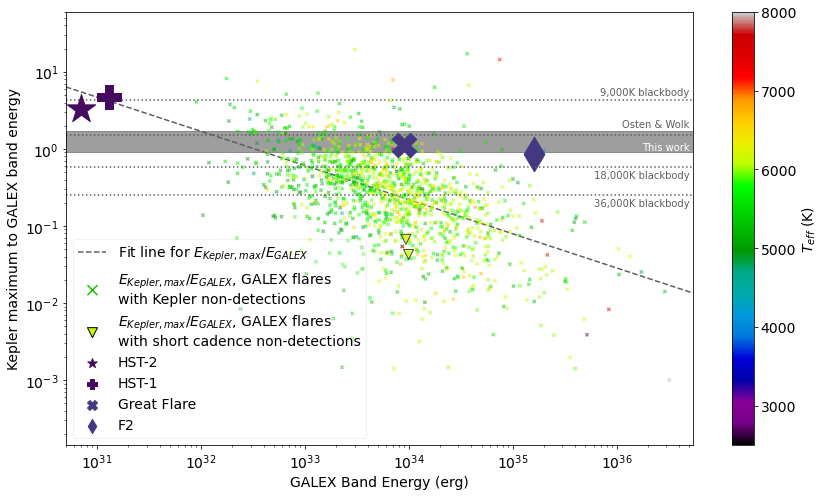

In [200]:
f, ax = plt.subplots(figsize=(12, 7))
ax.tick_params(axis='both', labelsize=14)


vmin, vmax = 2500, 8000

ax.scatter(comparison_flare_table["g_E"][loc],
           comparison_flare_table["k_E_max"][loc]/comparison_flare_table["g_E"][loc],  
           linestyle='None',marker='x', c=comparison_flare_table["Teff"][loc], cmap='nipy_spectral',
           alpha=0.5, s=10, label="$E_{Kepler,max}/E_{GALEX}$, GALEX flares\nwith Kepler non-detections",
           vmin=vmin, vmax=vmax)

ax.scatter(sc_comparison_flares["g_E"], sc_comparison_flares["k_E_max"]/sc_comparison_flares["g_E"], 
           marker='v', c=comparison_flare_table[comparison_flare_table["KID"] == sc_comparison_flares["KID"][0]]["Teff"], 
           s=100, cmap='nipy_spectral', edgecolor='k',
           alpha=0.7, label="$E_{Kepler,max}/E_{GALEX}$, GALEX flares\nwith short cadence non-detections",
           vmin=vmin, vmax=vmax)

sc = ax.scatter([],[],c=[], cmap='nipy_spectral', vmin=vmin, vmax=vmax)
cbar = plt.colorbar(sc)
cbar.ax.set_ylabel('$T_{eff}$ (K)', fontsize=14)
cbar.ax.tick_params(labelsize=14)


frac = .16/.106
ax.axhline(frac, color="#5e5e5e", ls=":")
ax.text(x=5*10**36, y=frac, s="Osten & Wolk\n\n", va='bottom', ha="right", linespacing=.1, color="#5e5e5e")

bb = models.BlackBody(temperature=9000*u.K)
frac = bb(arhap.Kepler_lamda)/bb(arhap.GALEX_lamda)
ax.axhline(frac, color="#5e5e5e", ls=":", zorder=0)
ax.text(x=5*10**36, y=frac, s="9,000K blackbody\n", va='bottom', ha="right", linespacing=.1, color="#5e5e5e")

bb = models.BlackBody(temperature=18000*u.K)
frac = bb(arhap.Kepler_lamda)/bb(arhap.GALEX_lamda)
ax.axhline(frac, color="#5e5e5e", ls=":")
ax.text(x=5*10**36, y=frac, s="\n18,000K blackbody", va='top', ha="right", linespacing=.1, color="#5e5e5e")

bb = models.BlackBody(temperature=36000*u.K)
frac = bb(arhap.Kepler_lamda)/bb(arhap.GALEX_lamda)
ax.axhline(frac, color="#5e5e5e", ls=":")
ax.text(x=5*10**36, y=frac, s="\n36,000K blackbody", va='top', ha="right", linespacing=.1, color="#5e5e5e")

# Note: the model ratios are galex/kepler so we need to invert them for this plot
ax.axhspan(1/np.max(gal_kep_ratios), 1/np.min(gal_kep_ratios) , color='#5e5e5e', alpha=0.6, zorder=0)
ax.text(x=5*10**36, y=1, s="This work\n", va='center', ha="right", linespacing=.2, color="#ffffff")

for row in lit_vals:
    ax.scatter(row["NUV"], row["optical"]/row["NUV"], marker=row["shape"], c=row["Teff"], 
               s=row["size"], label=row["Name"], vmin=vmin, vmax=vmax)

ax.set_xlabel("GALEX Band Energy (erg)", fontsize=14)
ax.set_ylabel("Kepler maximum to GALEX band energy", fontsize=14)

ax.set_xlim(5e+30, 5.40602514020026e+36)
ax.set_ylim(1/7000, 60)

xes = np.linspace(*ax.get_xlim(),10)
ax.plot(xes, np.exp(b)*np.power(xes,m), "--", color="#5e5e5e", label="Fit line for $E_{Kepler,max}/E_{GALEX}$", zorder=0)

ax.loglog()

lg = ax.legend(fontsize=14, loc="lower left", framealpha=.25)#, markerscale=.4)

lg.legendHandles[0].set_alpha(1)
lg.legendHandles[1].set_color("#17be00")
for handle in lg.legendHandles[1:]:
    handle.set_sizes([100])
    handle.set_alpha(1)

plt.tight_layout()

f.savefig("../plots/gal_vs_kep_with_lit.pdf")

plt.show()